# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 5.24 s, sys: 3.01 s, total: 8.24 s
Wall time: 12.9 s


,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,...,address_count_30,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,fulladdress_count_7,address_count_7,address_count_0_by_30,record,fraud_label
0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,0.0
1,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,2.0,1.0
2,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,3.0,0.0
3,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,4.0,0.0
4,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 15

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'homephone_count_7',
 'zip5_count_1',
 'max_count_by_homephone_3',
 'fulladdress_count_30',
 'max_count_by_fulladdress_7',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'ssn_count_30',
 'max_count_by_address_7',
 'address_day_since',
 'address_count_30',
 'max_count_by_address_3',
 'address_count_14']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [5]:
vars.shape

(1000000, 17)

In [6]:
vars['Fraud'].sum()

14393.0

In [7]:
vars.head(10)

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
5,6.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,12.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
6,7.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
7,8.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
8,9.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
9,10.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,12.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [8]:
vars.shape

(1000000, 17)

In [9]:
vars.describe()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924,1.107885,45.024781,1.090849,1.081907,1.060918
std,288675.278933,0.119104,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573,1.073310,105.022153,0.935591,0.965124,0.698980
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000,30.000000,365.000000,54.000000,30.000000,30.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924,1.107885,45.024781,1.090849,1.081907,1.060918
std,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573,1.073310,105.022153,0.935591,0.965124,0.698980
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000,30.000000,365.000000,54.000000,30.000000,30.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,-2.378897e-17,6.323830e-19,1.901235e-17,7.516121e-17,-3.606715e-17,-5.057821e-17,-4.071588e-17,-6.039613e-18,2.282263e-17,-7.723600e-18,-2.788170e-17,-2.282263e-17,6.929213e-17,-2.454925e-17,1.140421e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.299119e+00,-1.328419e-01,-1.004119e-01,-1.861493e+00,-4.031042e-01,-1.385946e-01,-1.179563e-01,-4.287170e-01,-1.347272e-01,-1.008464e-01,-1.102396e-01
25%,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,-3.744425e-01,-4.031042e-01,-1.385946e-01,-1.179563e-01,-4.287170e-01,-1.347272e-01,-1.008464e-01,-1.102396e-01
50%,-1.659633e-01,-9.468038e-02,5.704125e-02,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,1.212411e-01,-4.031042e-01,-1.385946e-01,-1.179563e-01,-4.287170e-01,-1.347272e-01,-1.008464e-01,-1.102396e-01
75%,-1.659633e-01,-9.468038e-02,5.704125e-02,5.584938e-01,3.872181e-01,-1.328419e-01,-1.004119e-01,6.169247e-01,-4.031042e-01,-1.385946e-01,-1.179563e-01,-4.287170e-01,-1.347272e-01,-1.008464e-01,-1.102396e-01
max,1.449903e+01,1.824326e+01,1.030972e+01,1.086853e+01,1.031208e+01,1.585223e+01,1.528096e+01,1.001288e+01,3.279624e+00,1.703702e+01,1.434394e+01,3.046740e+00,1.663211e+01,1.527529e+01,1.609925e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

(30, 15)
CPU times: user 48.1 s, sys: 5.56 s, total: 53.6 s
Wall time: 15.2 s


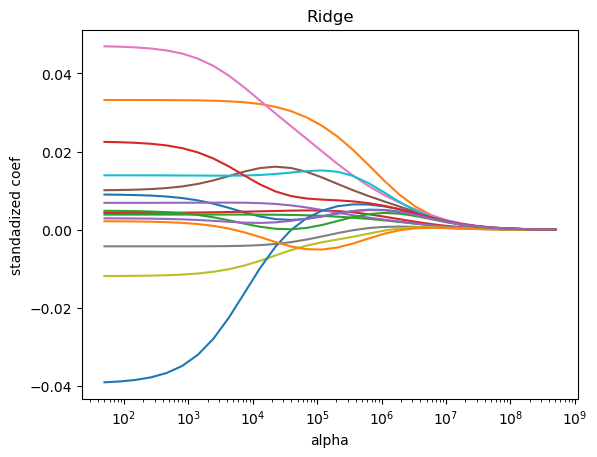

In [19]:
%%time
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
print(np.shape(coefs))

%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [20]:
# %%time
# # sometimes this cell takes a long time. It's fine to comment out this cell since it's not really important
# alphas = 10**np.linspace(-5,0,30)*0.5
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance 
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('alpha')
# plt.ylabel('standerdized coef') 
# plt.title('Lasso')
# plt.legend()
# plt.savefig('lasso.png')

## Look at PCA

In [21]:
len(X_trntst.columns)

15

In [22]:
X_trntst_save = X_trntst.copy()

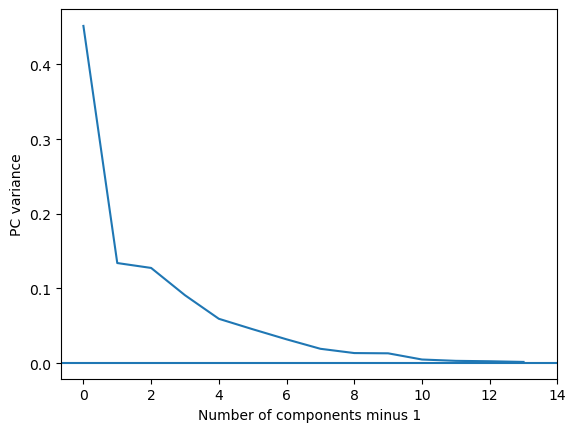

In [23]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [24]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.635119,0.019157,-0.439598,0.200586
1,-0.528726,0.492996,0.010737,0.167860
2,-0.675841,-0.205321,-0.664742,0.220724
3,-0.569448,0.268517,-0.214408,0.187998
4,-0.589809,0.156278,-0.326980,0.198067


In [25]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
833507,0.304788,-1.098806,1.406989,-2.135454
833508,-0.929349,-1.377477,-1.790556,0.306313
833509,3.660648,-3.154678,3.220353,-1.849102
833510,-0.782234,-0.679160,-1.115077,0.253450
833511,-0.518661,-0.122908,-0.739493,0.297359


In [26]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.001982,-0.001123,-0.001046,-0.000449,-0.000264,0.000321,0.001752,0.000159,-0.031511,-0.001817,0.001644,-0.031534,0.000023,0.001705,0.000631
std,1.006220,0.989478,1.000361,1.003332,0.998779,1.004381,1.012285,0.999543,0.981284,0.988286,1.010514,0.983370,1.001944,1.011024,1.005130
min,-0.165963,-0.094680,-0.791614,-0.572324,-1.299119,-0.132842,-0.100412,-1.861493,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.110240
25%,-0.165963,-0.094680,-0.791614,-0.572324,-0.174894,-0.132842,-0.100412,-0.374442,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.110240
50%,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.121241,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.110240
75%,-0.165963,-0.094680,0.057041,0.558494,0.387218,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.110240
max,14.499030,18.243255,10.309721,10.868526,10.312079,15.852230,15.280956,10.012880,3.279624,17.037019,14.343941,3.046740,16.632107,15.275285,16.099253


In [27]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.049135,-0.135031,0.124104,-0.179490
std,2.490898,1.468557,1.418669,1.284383
min,-0.929349,-15.323151,-10.517381,-3.527686
25%,-0.564859,-0.879272,-0.552170,-0.268017
50%,-0.371546,0.071783,-0.009885,0.188463
75%,-0.013717,0.657861,0.631712,0.263519
max,43.935187,11.745724,20.919623,18.473110


In [28]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [29]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,-6.819789e-18,-2.250530e-18,3.723605e-17,-1.636749e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.571516e-01,-1.079788e+01,-8.073403e+00,-3.132106e+00
25%,-2.284286e-01,-4.419243e-01,-4.597678e-01,1.320628e-01
50%,-1.602154e-01,1.297918e-01,-7.364853e-02,1.730916e-01
75%,-5.991122e-02,5.206502e-01,3.213874e-01,2.364737e-01
max,1.693369e+01,8.025780e+00,1.539405e+01,1.856537e+01


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.018883,-0.095238,0.089754,-0.153677
std,0.957260,1.035779,1.025997,1.099672
min,-0.357152,-10.807478,-7.606285,-3.020358
25%,-0.217077,-0.620154,-0.399336,-0.229473
50%,-0.142786,0.050629,-0.007149,0.161360
75%,-0.005271,0.463992,0.456861,0.225621
max,16.884425,8.284305,15.129300,15.816430


In [31]:
X_trntst_pca.shape

(833507, 4)

In [32]:
X_oot_orig_pca.shape

(166493, 4)

## Subsample the larger class if desired

In [33]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 15) 23841


In [34]:
niter = 0
nitermax = 3
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [35]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [36]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=1000,
        penalty='l2',
        C=0.5,
        class_weight='balanced',
        solver='lbfgs')
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.600571292549393 0.6141470180305132 0.5725062866722548
1 0.6039615703949709 0.6057046979865772 0.5733445096395641
2 0.6100390671244229 0.5949438202247191 0.5733445096395641
trn    0.604857
tst    0.604932
oot    0.573065
dtype: float64
CPU times: user 2min 52s, sys: 24.2 s, total: 3min 16s
Wall time: 51.1 s


uncomment and edit

In [37]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mss = 80
    #msl = int(mss/2)
    msl = 30
    model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=mss,
        min_samples_leaf=msl,
        splitter ='best',
        criterion = 'entropy')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.6199904580152672 0.6323488821418713 0.5859178541492037
1 0.6261648745519713 0.6183667858124828 0.588013411567477
2 0.622603550295858 0.6207478211976385 0.5859178541492037
trn    0.622920
tst    0.623821
oot    0.586616
dtype: float64
CPU times: user 31.7 s, sys: 179 ms, total: 31.9 s
Wall time: 31.9 s


In [38]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mss = 20
    msl = int(mss/2)
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=8,
        min_samples_split=mss,
        min_samples_leaf=msl,
        max_features='sqrt',
        criterion='entropy')
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6232261116367077 0.6192621796676993 0.5884325230511316
1 0.6194480634845434 0.6184062850729517 0.5859178541492037
2 0.6214217557251909 0.6146839635661054 0.5859178541492037
trn    0.621365
tst    0.617451
oot    0.586756
dtype: float64
CPU times: user 3min 37s, sys: 0 ns, total: 3min 37s
Wall time: 3min 37s


In [39]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        n_estimators=150,
        learning_rate = 0.05,
        max_depth = 8,
        num_leaves = 31,
        min_child_samples = 20)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 8372, number of negative: 575082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 583454, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014349 -> initscore=-4.229620
[LightGBM] [Info] Start training from score -4.229620
0 0.6305542283803154 0.6341127922971114 0.5943000838222967
[LightGBM] [Info] Number of positive: 8416, number of negative: 575038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train 

In [40]:
# %pip install imblearn

In [41]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier(
#         n_estimators=150,
#         learning_rate = 0.01,
#         max_depth = 8,
#         num_leaves = 31,
#         min_child_samples = 20)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(
        hidden_layer_sizes=(40,10),
        alpha=0.000005,solver='adam',
        activation='relu',
        max_iter=1000,
        learning_rate='invscaling',
        learning_rate_init=0.001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6286358779532233 0.625 0.5938809723386421
1 0.6282879005260641 0.6170738402415592 0.5884325230511316
2 0.6264266384280504 0.6185860889395667 0.5917854149203688
trn    0.627783
tst    0.620220
oot    0.591366
dtype: float64
CPU times: user 1min 32s, sys: 1.51 s, total: 1min 34s
Wall time: 1min 16s


In [43]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [44]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [45]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, iterations=1000, 
             scale_pos_weight = 20,
             depth=6,
             learning_rate=0.015,
             l2_leaf_reg=5)
#

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6363960961675792 0.6147018030513176 0.5917854149203688
1 0.6312320230105465 0.6257166257166257 0.5930427493713327
2 0.634750939849624 0.6174535050071531 0.5934618608549874
trn    0.634126
tst    0.619291
oot    0.592763
dtype: float64
CPU times: user 21min 6s, sys: 8min 3s, total: 29min 9s
Wall time: 4min 37s


In [46]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)
    
# #     model = svm.SVC(
# #         C=.1, 
# # #         gamma=100,
# # #         kernel='linear',
# #         kernel='poly',
# #         probability=True)

#     model = CatBoostClassifier(verbose=0, iterations=100)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [47]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=80, depth=5)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # XGB

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(
#         booster='gbtree',
#         max_depth=5, 
#         min_child_weight=75,
#         gamma=0.01, 
#     )

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [50]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=100) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [51]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [52]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.600571,0.614147,0.572506
1,log reg,0.603962,0.605705,0.573345
2,log reg,0.610039,0.594944,0.573345
3,DT,0.61999,0.632349,0.585918
4,DT,0.626165,0.618367,0.588013
5,DT,0.622604,0.620748,0.585918
6,RF,0.623226,0.619262,0.588433
7,RF,0.619448,0.618406,0.585918
8,RF,0.621422,0.614684,0.585918
9,LGBM,0.630554,0.634113,0.5943


In [53]:
df.shape

(18, 4)

In [54]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.600571
1,log reg,Trn,0.603962
2,log reg,Trn,0.610039
3,DT,Trn,0.61999
4,DT,Trn,0.626165


In [55]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.600571
1,log reg,Trn,0.603962
2,log reg,Trn,0.610039
3,DT,Trn,0.61999
4,DT,Trn,0.626165


In [56]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT          0.62292  0.003099  0.623821  0.007481  0.586616  0.001210
LGBM       0.631793  0.001075  0.632908  0.001057  0.594579  0.000484
NN         0.627783  0.001188   0.62022  0.004208  0.591366  0.002748
RF         0.621365  0.001890  0.617451  0.002434  0.586756  0.001452
cat boost  0.634126  0.002638  0.619291  0.005733  0.592763  0.000872
log reg    0.604857  0.004797  0.604932  0.009625  0.573065  0.000484

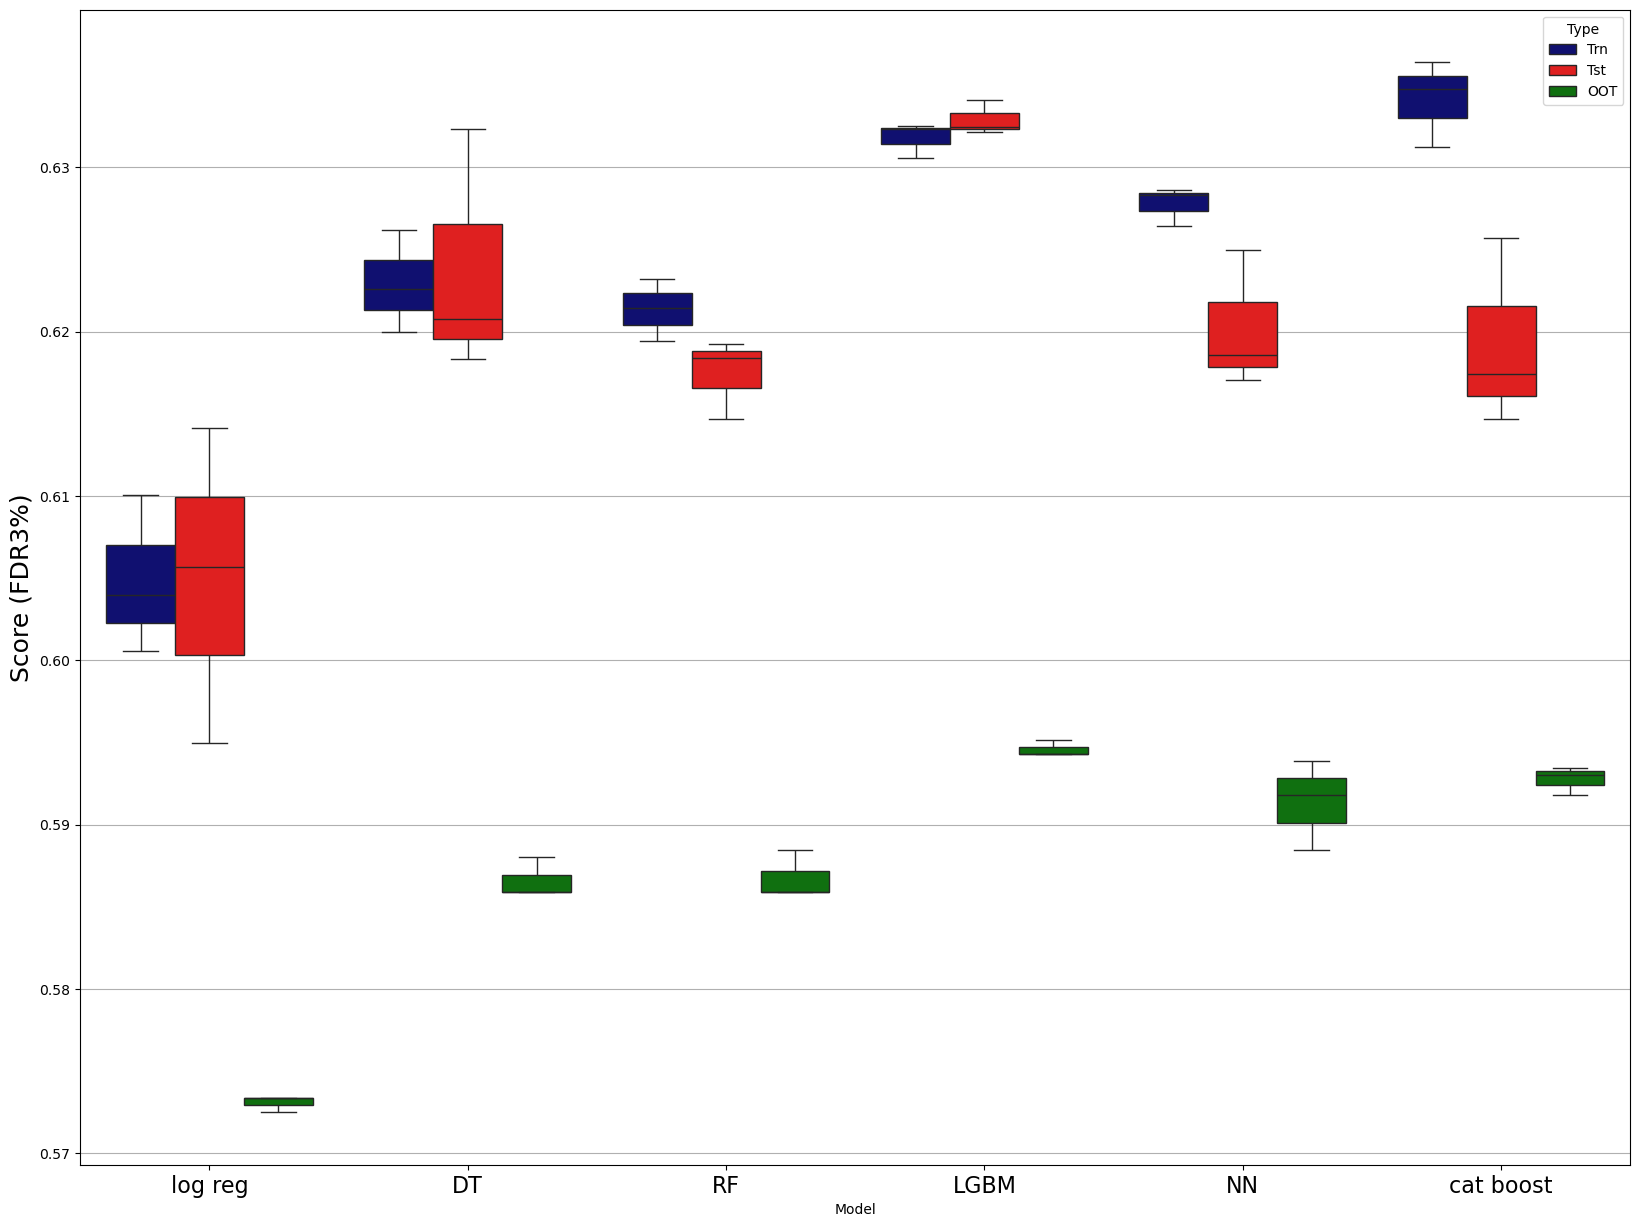

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model', y='Value', hue='Type', data=df_compare, palette=['navy','r','g'])


plt.ylabel('Score (FDR3%)', fontsize=18)
plt.xticks(fontsize=16)
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:12:55.471541


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [59]:
%%time

for niter in range(20):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = lgb.LGBMClassifier(
        n_estimators=150,
        learning_rate = 0.05,
        max_depth = 8,
        num_leaves = 31,
        min_child_samples = 20)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .59): break
    
print(FDR3.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 8450, number of negative: 575004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 583454, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014483 -> initscore=-4.220211
[LightGBM] [Info] Start training from score -4.220211
0 0.6366863905325444 0.6238403148720832 0.595138306789606
trn    0.634223
tst    0.622337
oot    0.593881
dtype: float64
CPU times: user 24.1 s, sys: 372 ms, total: 24.4 s
Wall time: 6.56 s


In [60]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [61]:
X_trn_eval

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14,predicted,Fraud
436571,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005422,0.0
339130,-0.165963,-0.094680,-0.791614,-0.572324,-1.299119,-0.132842,-0.100412,-1.861493,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005015,0.0
176416,-0.165963,-0.094680,-0.791614,-0.572324,0.949331,-0.132842,-0.100412,1.112608,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005848,0.0
651097,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,-0.374442,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005213,0.0
14734,0.764944,18.243255,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.616925,-0.403104,13.107418,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.778293,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76918,0.764944,2.260897,0.057041,-0.572324,-0.174894,-0.132842,1.429595,-0.126601,-0.403104,-0.138595,1.216046,-0.428717,-0.134727,-0.100846,-0.11024,0.005233,0.0
536437,-0.165963,-0.094680,-0.791614,-0.572324,-0.737007,-0.132842,-0.100412,-1.613651,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.004342,0.0
379785,0.764944,-0.094680,0.057041,-0.572324,0.387218,2.363186,-0.100412,0.369083,3.118190,3.172909,-0.117956,2.894391,1.640150,-0.100846,-0.11024,0.005418,0.0
636792,-0.165963,-0.094680,0.057041,-0.572324,0.387218,-0.132842,-0.100412,0.121241,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005213,0.0


In [62]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14,predicted,Fraud
881892,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,5.325919,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
915263,14.49903,-0.09468,8.543596,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
915662,14.49903,-0.09468,10.240908,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
915422,14.49903,-0.09468,9.392252,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
880770,14.49903,-0.09468,10.240908,10.868526,10.312079,15.85223,15.280956,5.325919,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
916735,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
916945,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
917384,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
917348,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0
916736,14.49903,-0.09468,10.309721,10.868526,10.312079,15.85223,15.280956,7.556495,3.279624,-0.138595,14.343941,3.04674,16.632107,15.275285,16.099253,0.999451,1.0


In [63]:
cost_fraud = 4000
cost_fp = 100

for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,375.0,1290.0,22.522523,77.477477,1665.0,375.0,1290.0,0.228509,54.065381,53.836872,0.290698
2,2.0,1665.0,1569.0,96.0,94.234234,5.765766,3330.0,1944.0,1386.0,1.184593,58.088852,56.904259,1.402597
3,3.0,1665.0,1631.0,34.0,97.957958,2.042042,4995.0,3575.0,1420.0,2.178457,59.513831,57.335374,2.517606
4,4.0,1665.0,1653.0,12.0,99.279279,0.720721,6660.0,5228.0,1432.0,3.185726,60.016764,56.831038,3.650838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1655.0,10.0,99.399399,0.600601,159833.0,157492.0,2341.0,95.969093,98.113998,2.144905,67.275523
97,97.0,1665.0,1660.0,5.0,99.699700,0.300300,161498.0,159152.0,2346.0,96.980628,98.323554,1.342926,67.839727
98,98.0,1665.0,1647.0,18.0,98.918919,1.081081,163163.0,160799.0,2364.0,97.984242,99.077955,1.093713,68.019882
99,99.0,1665.0,1658.0,7.0,99.579580,0.420420,164828.0,162457.0,2371.0,98.994558,99.371333,0.376774,68.518347


In [64]:
FDR_trn
FDR_trn.to_csv('FDR_trn.csv', index=False)

In [65]:
FDR_tst
FDR_tst.to_csv('FDR_tst.csv', index=False)

In [66]:
FDR_oot
FDR_oot.to_csv('FDR_oot.csv', index=False)

### Financials

Max possible savings: 3,209,760,000.0


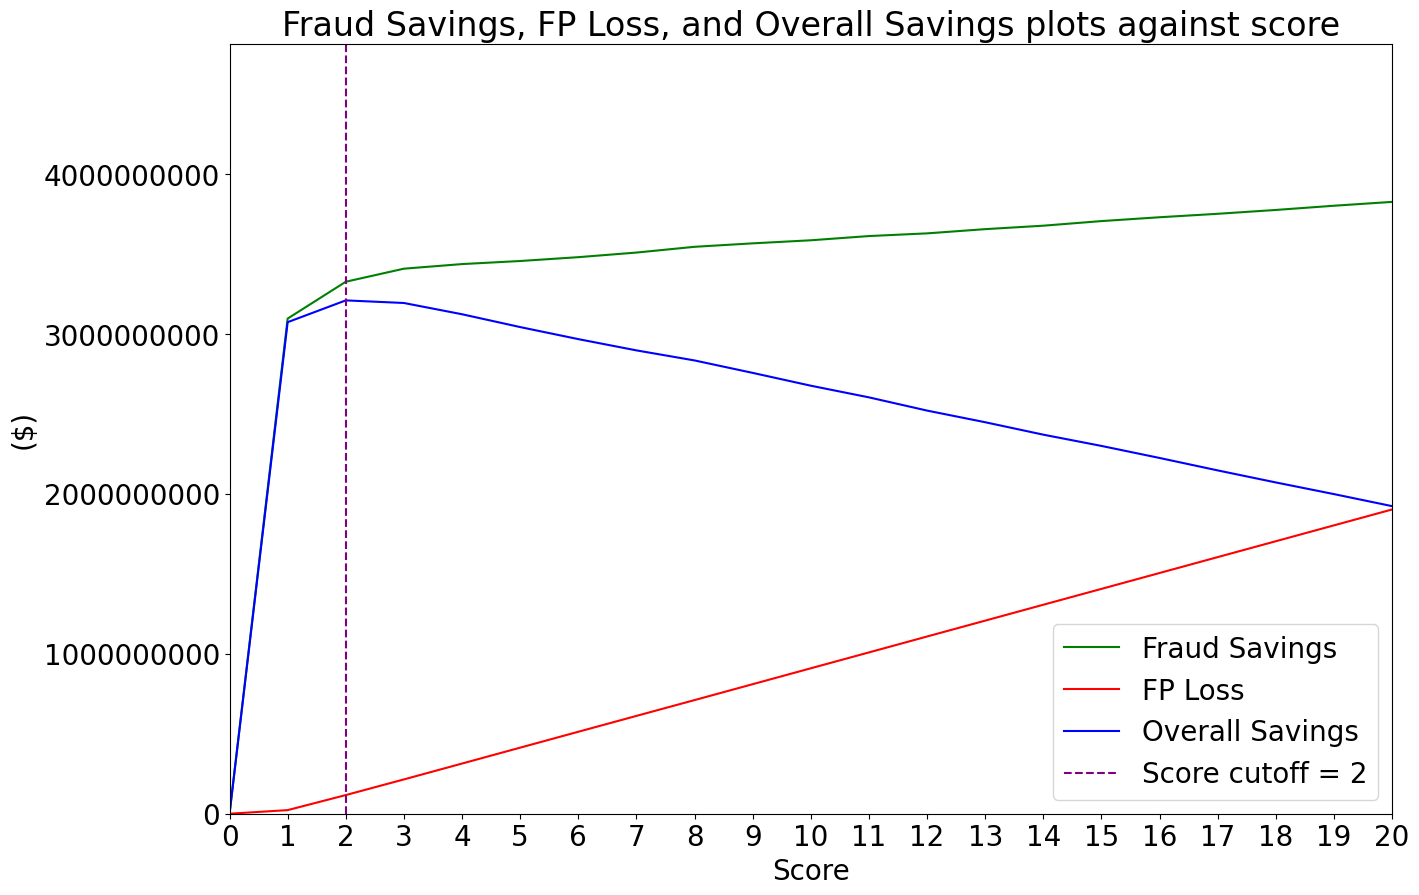

In [99]:
# # xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green', label='Fraud Savings')
plt.plot(Financials_oot['FP Loss'], color='red', label='FP Loss')
plt.plot(Financials_oot['Overall Savings'], color='blue', label='Overall Savings')
xlimit = 20
interval = 1
plt.axvline(x=2, color='purple', linestyle='--', label='Score cutoff = 2')  # Add vertical line
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.xlabel('Score')
plt.ylabel('($)')
plt.title("Fraud Savings, FP Loss, and Overall Savings plots against score")
plt.legend()
plt.savefig('savings.png', format='png')
plt.show()

In [68]:
blue_curve_value = Financials_oot.loc[5, 'Overall Savings']
blue_curve_value

3042900000.0

# Score Calibration

In [69]:
base = 800
delta = 30
odds_at_base = 1

In [70]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(1000000, 17)

In [71]:
df.head()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,max_count_by_address_7,address_day_since,address_count_30,max_count_by_address_3,address_count_14,predicted,Fraud
436571,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005422,0.0
339130,-0.165963,-0.094680,-0.791614,-0.572324,-1.299119,-0.132842,-0.100412,-1.861493,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005015,0.0
176416,-0.165963,-0.094680,-0.791614,-0.572324,0.949331,-0.132842,-0.100412,1.112608,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005848,0.0
651097,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,-0.374442,-0.403104,-0.138595,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.005213,0.0
14734,0.764944,18.243255,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.616925,-0.403104,13.107418,-0.117956,-0.428717,-0.134727,-0.100846,-0.11024,0.778293,1.0


In [72]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/tmp/ipykernel_947240/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/tmp/ipykernel_947240/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

,score_raw,Fraud
273870,0.000082,0.0
829576,0.000083,0.0
379677,0.000085,0.0
580390,0.000085,0.0
221841,0.000085,0.0


In [73]:
calib.shape

(1000000, 2)

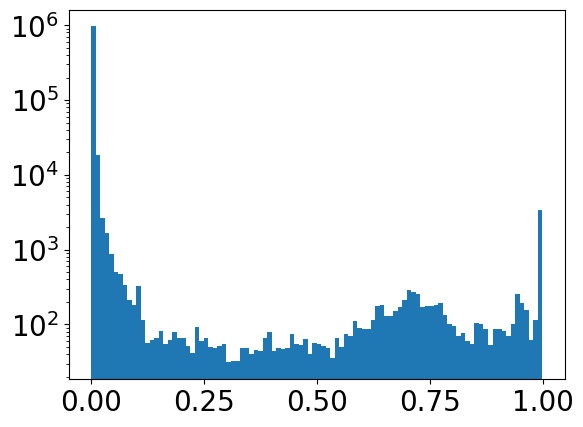

In [74]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [75]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=500
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [76]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

14393.0 985607.0


In [77]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,2000.0,1989.0,11.0,99.45,0.55,2000.0,1989.0,11.0,0.002450,0.55,0.005531,-7.498265,-7.498265
2,2.0,2000.0,1989.0,11.0,99.45,0.55,4000.0,3978.0,22.0,0.003640,0.55,0.005531,-7.498265,-7.498265
3,3.0,2000.0,1994.0,6.0,99.70,0.30,6000.0,5972.0,28.0,0.003884,0.30,0.003010,-8.376247,-7.498265
4,4.0,2000.0,1995.0,5.0,99.75,0.25,8000.0,7967.0,33.0,0.003960,0.25,0.002507,-8.639956,-7.498265
5,5.0,2000.0,1994.0,6.0,99.70,0.30,10000.0,9961.0,39.0,0.004066,0.30,0.003010,-8.376247,-7.498265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496.0,2000.0,980.0,1020.0,49.00,51.00,992000.0,984694.0,7306.0,0.544134,51.00,1.040817,0.057717,0.057717
497,497.0,2000.0,595.0,1405.0,29.75,70.25,994000.0,985289.0,8711.0,0.707406,70.25,2.361346,1.239610,1.239610
498,498.0,2000.0,265.0,1735.0,13.25,86.75,996000.0,985554.0,10446.0,0.844497,86.75,6.547174,2.710872,2.710872
499,499.0,2000.0,33.0,1967.0,1.65,98.35,998000.0,985587.0,12413.0,0.986692,98.35,59.606091,5.897388,5.897388


In [78]:
cal_bins.tail(20)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
481,481.0,2000.0,1978.0,22.0,98.90,1.10,962000.0,956703.0,5297.0,0.009673,1.10,0.011123,-6.490330,-6.086681
482,482.0,2000.0,1981.0,19.0,99.05,0.95,964000.0,958684.0,5316.0,0.010206,0.95,0.009592,-6.704010,-6.086681
483,483.0,2000.0,1983.0,17.0,99.15,0.85,966000.0,960667.0,5333.0,0.010948,0.85,0.008573,-6.865921,-6.086681
484,484.0,2000.0,1975.0,25.0,98.75,1.25,968000.0,962642.0,5358.0,0.011568,1.25,0.012659,-6.303723,-6.086681
485,485.0,2000.0,1983.0,17.0,99.15,0.85,970000.0,964625.0,5375.0,0.012209,0.85,0.008573,-6.865921,-6.086681
486,486.0,2000.0,1965.0,35.0,98.25,1.75,972000.0,966590.0,5410.0,0.013064,1.75,0.017812,-5.810989,-5.810989
487,487.0,2000.0,1962.0,38.0,98.10,1.90,974000.0,968552.0,5448.0,0.013937,1.90,0.019369,-5.690144,-5.690144
488,488.0,2000.0,1962.0,38.0,98.10,1.90,976000.0,970514.0,5486.0,0.015025,1.90,0.019369,-5.690144,-5.690144
489,489.0,2000.0,1969.0,31.0,98.45,1.55,978000.0,972483.0,5517.0,0.016509,1.55,0.015745,-5.989005,-5.690144
490,490.0,2000.0,1959.0,41.0,97.95,2.05,980000.0,974442.0,5558.0,0.017982,2.05,0.020930,-5.578314,-5.578314


In [79]:
temp = cal_bins.copy()
temp.drop(columns=['bin','log_odds_adj','%g','%b','tot','cg','cb'], inplace=True)
temp.tail(10)

,#recs,#g,#b,score_raw,prob(%),odds,log_odds
491,2000.0,1947.0,53.0,0.020413,2.65,0.027222,-5.199089
492,2000.0,1957.0,43.0,0.026787,2.15,0.021973,-5.508130
493,2000.0,1914.0,86.0,0.036736,4.30,0.044933,-4.476094
494,2000.0,1875.0,125.0,0.063442,6.25,0.066667,-3.906879
495,2000.0,1579.0,421.0,0.203430,21.05,0.266625,-1.907116
496,2000.0,980.0,1020.0,0.544134,51.00,1.040817,0.057717
497,2000.0,595.0,1405.0,0.707406,70.25,2.361346,1.239610
498,2000.0,265.0,1735.0,0.844497,86.75,6.547174,2.710872
499,2000.0,33.0,1967.0,0.986692,98.35,59.606091,5.897388
500,2000.0,20.0,1980.0,0.998811,99.00,99.000050,6.629357


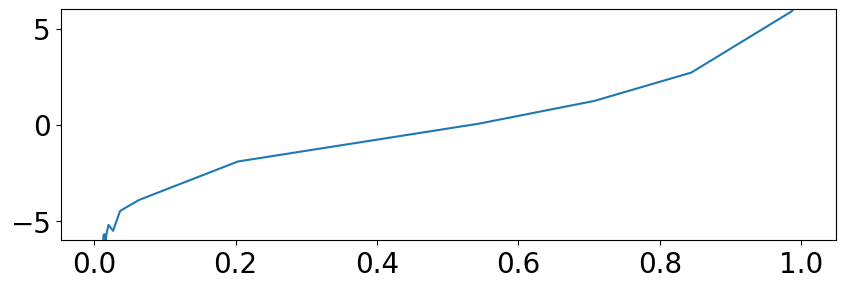

In [80]:
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])
plt.ylim([-6,6])
plt.show()

In [81]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [82]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.68480622  1.01011322 -0.00468565]


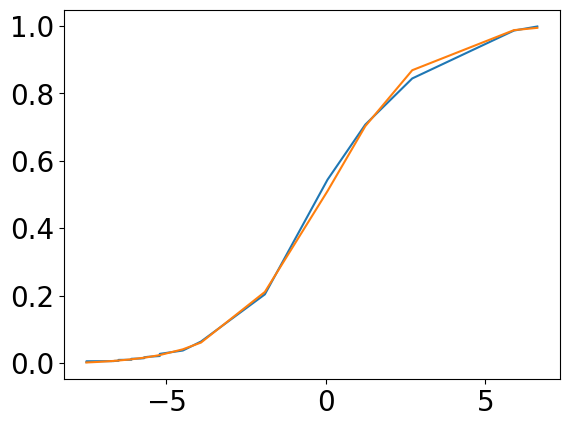

In [83]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

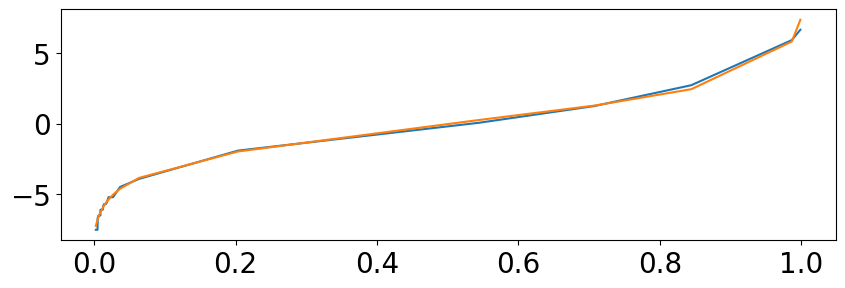

In [84]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [85]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,2000.0,1989.0,11.0,99.45,0.55,2000.0,1989.0,11.0,0.002450,0.55,0.005531,-7.498265,-7.498265,-7.221894
2,2.0,2000.0,1989.0,11.0,99.45,0.55,4000.0,3978.0,22.0,0.003640,0.55,0.005531,-7.498265,-7.498265,-6.994908
3,3.0,2000.0,1994.0,6.0,99.70,0.30,6000.0,5972.0,28.0,0.003884,0.30,0.003010,-8.376247,-7.498265,-6.952494
4,4.0,2000.0,1995.0,5.0,99.75,0.25,8000.0,7967.0,33.0,0.003960,0.25,0.002507,-8.639956,-7.498265,-6.939503
5,5.0,2000.0,1994.0,6.0,99.70,0.30,10000.0,9961.0,39.0,0.004066,0.30,0.003010,-8.376247,-7.498265,-6.921534
6,6.0,2000.0,1992.0,8.0,99.60,0.40,12000.0,11953.0,47.0,0.004170,0.40,0.004017,-7.959822,-7.498265,-6.904114
7,7.0,2000.0,1992.0,8.0,99.60,0.40,14000.0,13945.0,55.0,0.004272,0.40,0.004017,-7.959822,-7.498265,-6.887128
8,8.0,2000.0,1993.0,7.0,99.65,0.35,16000.0,15938.0,62.0,0.004333,0.35,0.003513,-8.153165,-7.498265,-6.877196
9,9.0,2000.0,1994.0,6.0,99.70,0.30,18000.0,17932.0,68.0,0.004356,0.30,0.003010,-8.376247,-7.498265,-6.873388
10,10.0,2000.0,1997.0,3.0,99.85,0.15,20000.0,19929.0,71.0,0.004386,0.15,0.001503,-9.378175,-7.498265,-6.868496


In [86]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/tmp/ipykernel_947240/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_947240/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [87]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
471,471.0,2000.0,1986.0,14.0,99.30,0.70,942000.0,936892.0,5108.0,0.008272,0.70,0.007050,-7.148192,-6.490330,-6.342317,609.730480
472,472.0,2000.0,1991.0,9.0,99.55,0.45,944000.0,938883.0,5117.0,0.008366,0.45,0.004521,-7.789192,-6.490330,-6.331539,610.053842
473,473.0,2000.0,1983.0,17.0,99.15,0.85,946000.0,940866.0,5134.0,0.008503,0.85,0.008573,-6.865921,-6.490330,-6.316133,610.516001
474,474.0,2000.0,1982.0,18.0,99.10,0.90,948000.0,942848.0,5152.0,0.008525,0.90,0.009082,-6.782736,-6.490330,-6.313604,610.591877
475,475.0,2000.0,1984.0,16.0,99.20,0.80,950000.0,944832.0,5168.0,0.008550,0.80,0.008065,-6.954106,-6.490330,-6.310889,610.673318
476,476.0,2000.0,1986.0,14.0,99.30,0.70,952000.0,946818.0,5182.0,0.008611,0.70,0.007050,-7.148192,-6.490330,-6.304107,610.876777
477,477.0,2000.0,1981.0,19.0,99.05,0.95,954000.0,948799.0,5201.0,0.008754,0.95,0.009592,-6.704010,-6.490330,-6.288248,611.352563
478,478.0,2000.0,1980.0,20.0,99.00,1.00,956000.0,950779.0,5221.0,0.008904,1.00,0.010102,-6.629284,-6.490330,-6.271770,611.846887
479,479.0,2000.0,1971.0,29.0,98.55,1.45,958000.0,952750.0,5250.0,0.009020,1.45,0.014714,-6.086681,-6.086681,-6.259175,612.224760
480,480.0,2000.0,1975.0,25.0,98.75,1.25,960000.0,954725.0,5275.0,0.009285,1.25,0.012659,-6.303723,-6.086681,-6.230875,613.073756


In [88]:
calib.head()

,score_raw,Fraud
273870,0.000082,0.0
829576,0.000083,0.0
379677,0.000085,0.0
580390,0.000085,0.0
221841,0.000085,0.0


In [89]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/tmp/ipykernel_947240/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_947240/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,score_raw,Fraud,score_calib
273870,0.000082,0.0,815.011554
829576,0.000083,0.0,815.011557
379677,0.000085,0.0,815.011568
580390,0.000085,0.0,815.011568
221841,0.000085,0.0,815.011568


In [90]:
calib.tail()

,score_raw,Fraud,score_calib
916818,0.999,1.0,820.000823
827454,0.999,1.0,820.000823
576989,0.999,1.0,820.000823
576728,0.999,1.0,820.000823
287526,0.999,1.0,820.000823


In [91]:
calib.describe()

,score_raw,Fraud,score_calib
count,1000000.000000,1000000.000000,1000000.000000
mean,0.014461,0.014393,815.084939
std,0.083196,0.119104,0.418615
min,0.000082,0.000000,815.011554
25%,0.005213,0.000000,815.038175
50%,0.005350,0.000000,815.038884
75%,0.005857,0.000000,815.041514
max,0.999000,1.000000,820.000823


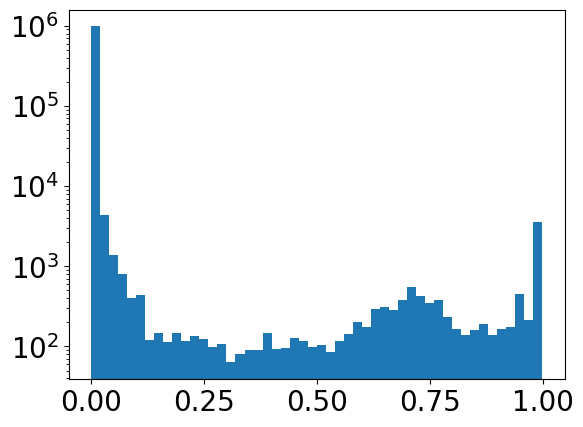

In [92]:
nbins=50
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

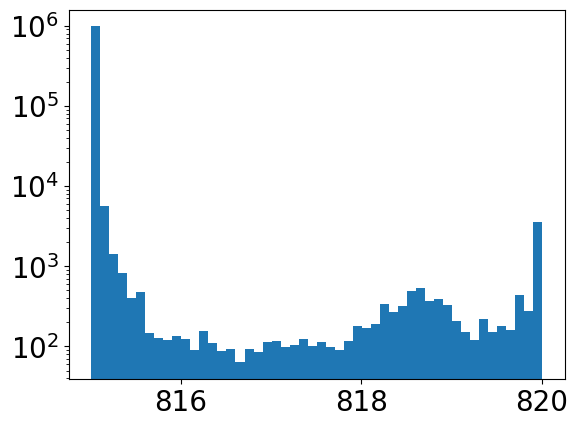

In [93]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

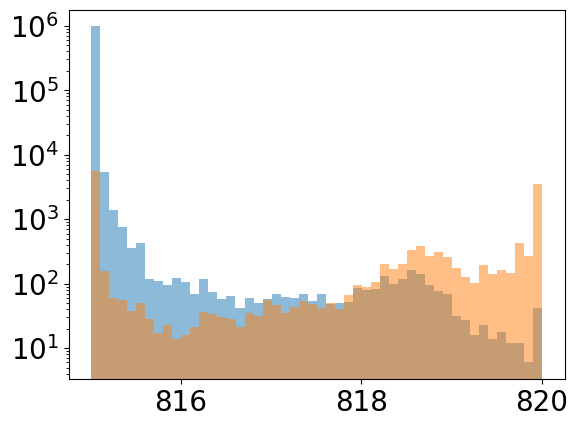

In [94]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [95]:
print("duration: ", datetime.now() - start_time)

duration:  0:13:18.927166


In [96]:
!pwd

/mnt/c/Users/nitya/OneDrive/Desktop/nvrsm/fraud analytics/PII Project 3
